# Process Mining Assignment
### Decision Miner

#### Group 3

**Members**
- Marit Bosch
- Tristán Gonzalez Fernandez
- Max de Leeuw
- Steven Verbeek
- Sterre van Zutphen

---

### Imports & Datasets

In [11]:
import pm4py
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


logs_Running_Examples = 'data/running-example.xes'
logs_Road_Traffic_Fine_Management_Process = 'data/Road_Traffic_Fine_Management_Process.xes'
logs_BPI_Challenge = 'data/BPI Challenge 2017.xes'

LOG = logs_Road_Traffic_Fine_Management_Process

In [12]:
log = xes_importer.apply(LOG)

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

In [13]:
df = pm4py.convert_to_dataframe(log)

print("\n================= LOG SUMMARY =================\n")
print(f"Total traces: {len(log)}")
print(f"Total events: {len(df)}")
print(f"Log columns: {list(df.columns)}")



================= LOG SUMMARY =================

Total traces: 150370
Total events: 561470
Log columns: ['amount', 'org:resource', 'dismissal', 'concept:name', 'vehicleClass', 'totalPaymentAmount', 'lifecycle:transition', 'time:timestamp', 'article', 'points', 'case:concept:name', 'expense', 'notificationType', 'lastSent', 'paymentAmount', 'matricola']


In [14]:
df

amount org:resource dismissal                concept:name  \
0         35.0          561       NIL                 Create Fine   
1          NaN          NaN       NaN                   Send Fine   
2         35.0          561       NIL                 Create Fine   
3          NaN          NaN       NaN                   Send Fine   
4          NaN          NaN       NaN    Insert Fine Notification   
...        ...          ...       ...                         ...   
561465   131.0           25       NIL                 Create Fine   
561466     NaN          NaN       NaN                   Send Fine   
561467     NaN          NaN       NaN    Insert Fine Notification   
561468   262.0          NaN       NaN                 Add penalty   
561469     NaN          NaN       NaN  Send for Credit Collection   

       vehicleClass  totalPaymentAmount lifecycle:transition  \
0                 A                 0.0             complete   
1               NaN                 NaN             complete   
2                 A                 0.0             complete   
3               NaN                 NaN             complete   
4               NaN                 NaN             complete   
...             ...                 ...                  ...   
561465            A                 0.0             complete   
561466          NaN                 NaN             complete   
561467          NaN                 NaN             complete   
561468          NaN                 NaN             complete   
561469          NaN                 NaN             complete   

                  time:timestamp  article  points case:concept:name  expense  \
0      2006-07-24 00:00:00+00:00    157.0     0.0                A1      NaN   
1      2006-12-05 00:00:00+00:00      NaN     NaN                A1    11.00   
2      2006-08-02 00:00:00+00:00    157.0     0.0              A100      NaN   
3      2006-12-12 00:00:00+00:00      NaN     NaN              A100    11.00   
4      2007-01-15 00:00:00+00:00      NaN     NaN              A100      NaN   
...                          ...      ...     ...               ...      ...   
561465 2002-09-07 00:00:00+00:00    142.0     0.0             V9999      NaN   
561466 2002-10-25 00:00:00+00:00      NaN     NaN             V9999    15.16   
561467 2002-11-04 00:00:00+00:00      NaN     NaN             V9999      NaN   
561468 2003-01-03 00:00:00+00:00      NaN     NaN             V9999      NaN   
561469 2004-01-10 00:00:00+00:00      NaN     NaN             V9999      NaN   

       notificationType lastSent  paymentAmount  matricola  
0                   NaN      NaN            NaN        NaN  
1                   NaN      NaN            NaN        NaN  
2                   NaN      NaN            NaN        NaN  
3                   NaN      NaN            NaN        NaN  
4                     P        P            NaN        NaN  
...                 ...      ...            ...        ...  
561465              NaN      NaN            NaN        NaN  
561466              NaN      NaN            NaN        NaN  
561467                P        N            NaN        NaN  
561468              NaN      NaN            NaN        NaN  
561469              NaN      NaN            NaN        NaN  

[561470 rows x 16 columns]

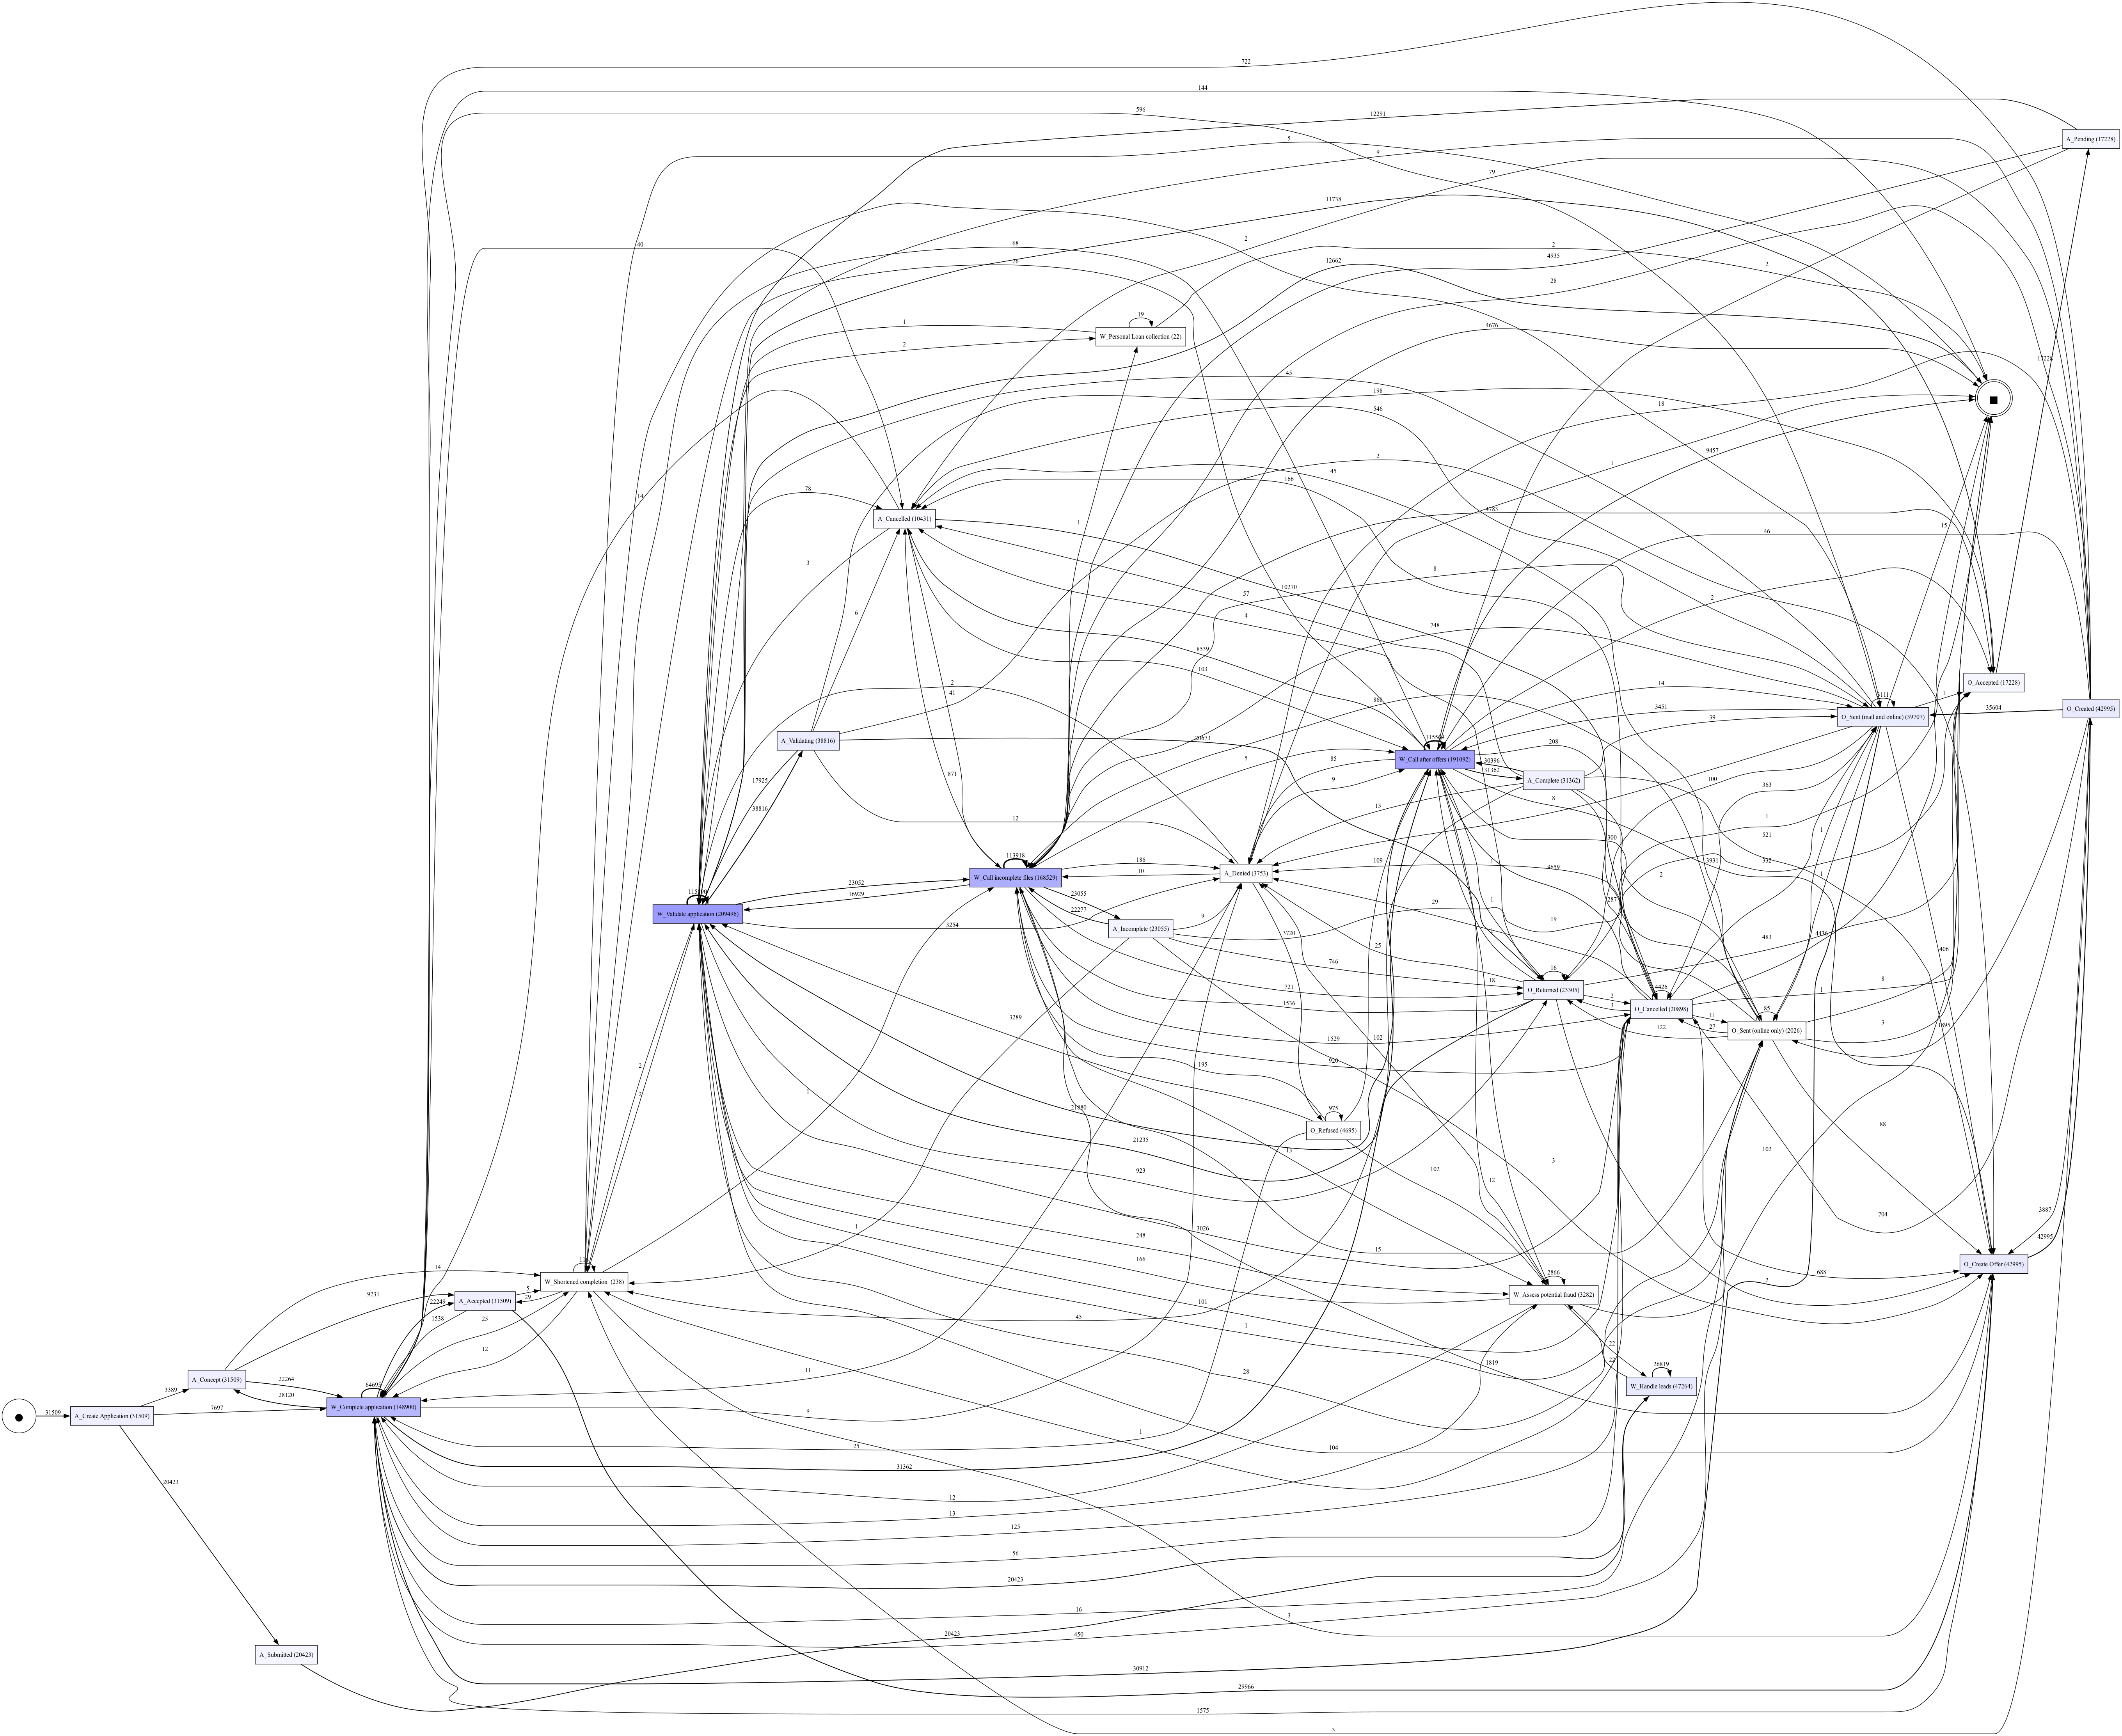

In [67]:
dfg, stat, end = pm4py.discover_dfg(log=log, case_id_key=1)
pm4py.view_dfg(dfg, stat, end)

In [6]:
def find_decision_points(petri):
    decision_points = {}
    for i, place in enumerate(petri.places):
        # outgoing transitions with labels
        outgoing_transitions = [arc.target for arc in petri.arcs if arc.source == place and getattr(arc.target, "label", None)]
        if len(outgoing_transitions) > 1:  # only decision points
            decision_points[len(decision_points)] = [t.label for t in outgoing_transitions]

    return decision_points

In [72]:
def find_decision_points(petri):
    """
    Discover decision points and their decision classes (possible choices)
    according to Algorithm 1 in decision mining literature.
    """
    decision_points = {}

    # Step 1: identify places with multiple outgoing arcs (XOR-split candidates)
    for place in petri.places:
        outgoing_transitions = [arc.target for arc in petri.arcs if arc.source == place]
        if len(outgoing_transitions) > 1:
            decision_classes = []
            empty = 0

            for t in outgoing_transitions:
                if is_visible(t):
                    current_class = {t.label}
                else:
                    current_class = trace_decision_class(t, petri)
                if current_class:
                    decision_classes.append(current_class)
                else:
                    empty += 1


            if len(decision_classes) > 0:
                if empty > 0:
                    decision_classes.append({})
                    decision_points[place.name] = decision_classes
                else:
                    decision_points[place.name] = decision_classes

    return decision_points


def trace_decision_class(t, petri, visited=None):
    """
    Recursive exploration to find visible successors of invisible transitions.
    Handles loops by tracking visited nodes.
    """
    if visited is None:
        visited = set()
    if t in visited:
        # Loop detected, stop recursion to avoid infinite traversal
        return set()
    visited.add(t)

    decision_class = set()
    succ_places = [arc.target for arc in petri.arcs if arc.source == t]

    for p in succ_places:
        if is_join_construct(p, petri) and not is_within_loop(p, petri):
            return set()

        # Otherwise, keep exploring
        succ_transitions = [arc.target for arc in petri.arcs if arc.source == p]
        for t2 in succ_transitions:
            if is_visible(t2) and not is_duplicate(t2, petri):
                decision_class.add(t2.label)
            else:
                result = trace_decision_class(t2, petri, visited)
                decision_class |= result

    return decision_class

def is_within_loop(place, petri):

    visited = set()

    def dfs(p):
        if p in visited:
            return True
        visited.add(p)
        for arc in petri.arcs:
            if arc.source == p and isinstance(arc.target, type(p)):
                continue
            if hasattr(arc.target, 'label') and not arc.target.label:
                # tau transition
                succ_places = [a.target for a in petri.arcs if a.source == arc.target]
                for sp in succ_places:
                    if sp == place or dfs(sp):
                        return True
        return False

    return dfs(place)

def is_visible(t):
    return t.label

def is_duplicate(t, petri):
    """Check if multiple transitions share the same label."""
    if not t.label:
        return False
    same_label = [tr for tr in petri.transitions if getattr(tr, "label", None) == t.label]
    return len(same_label) > 1

def is_join_construct(place, petri):
    """A place is a join if it has multiple incoming arcs."""
    incoming = [arc.source for arc in petri.arcs if arc.target == place]
    return len(incoming) > 1

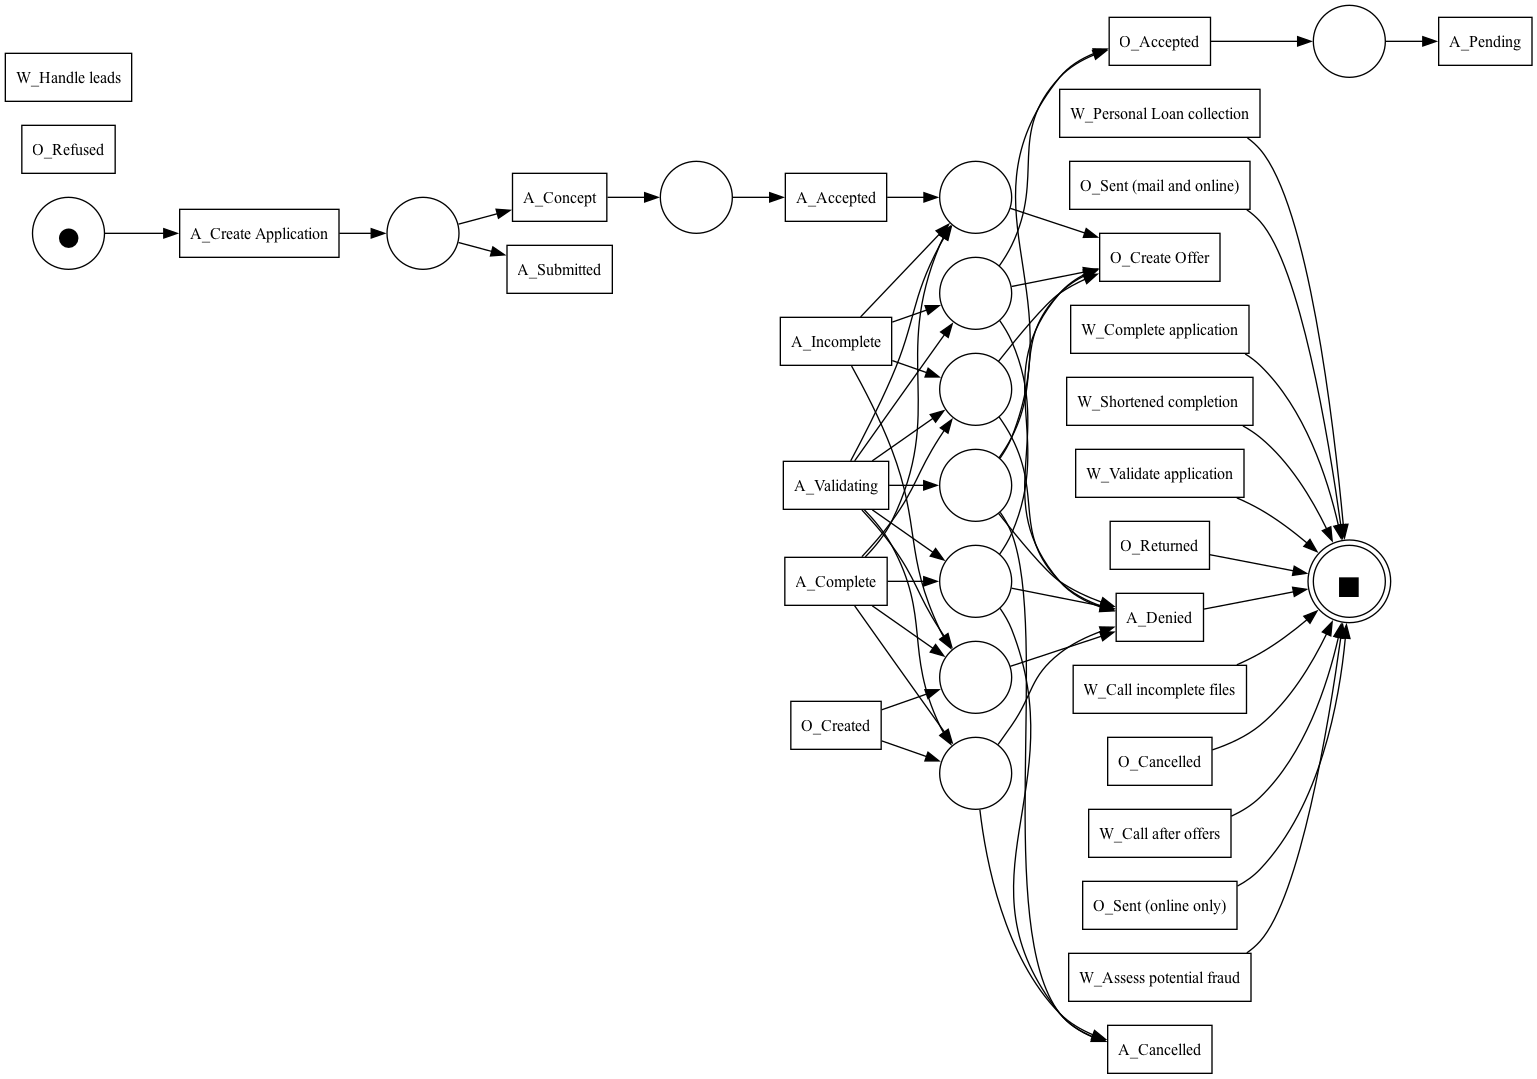

{"({'A_Create Application'}, {'A_Concept', 'A_Submitted'})": [{'A_Submitted'}, {'A_Concept'}], "({'A_Complete', 'A_Incomplete', 'A_Validating'}, {'O_Create Offer', 'A_Denied'})": [{'A_Denied'}, {'O_Create Offer'}], "({'A_Complete', 'A_Validating'}, {'A_Cancelled', 'O_Create Offer', 'A_Denied'})": [{'A_Denied'}, {'O_Create Offer'}, {'A_Cancelled'}], "({'O_Created', 'A_Complete', 'A_Validating'}, {'A_Cancelled', 'A_Denied'})": [{'A_Denied'}, {'A_Cancelled'}], "({'A_Validating'}, {'O_Accepted', 'A_Cancelled', 'O_Create Offer', 'A_Denied'})": [{'A_Denied'}, {'A_Cancelled'}, {'O_Create Offer'}, {'O_Accepted'}], "({'A_Incomplete', 'A_Validating'}, {'O_Accepted', 'O_Create Offer', 'A_Denied'})": [{'O_Accepted'}, {'O_Create Offer'}, {'A_Denied'}]}


In [54]:
petri_alpha, im_alpha, fm_alpha = pm4py.discover_petri_net_alpha(log=log)

pm4py.view_petri_net(petri_alpha, im_alpha, fm_alpha, log=log)


decision_points_alpha = find_decision_points(petri_alpha)
print(decision_points_alpha)

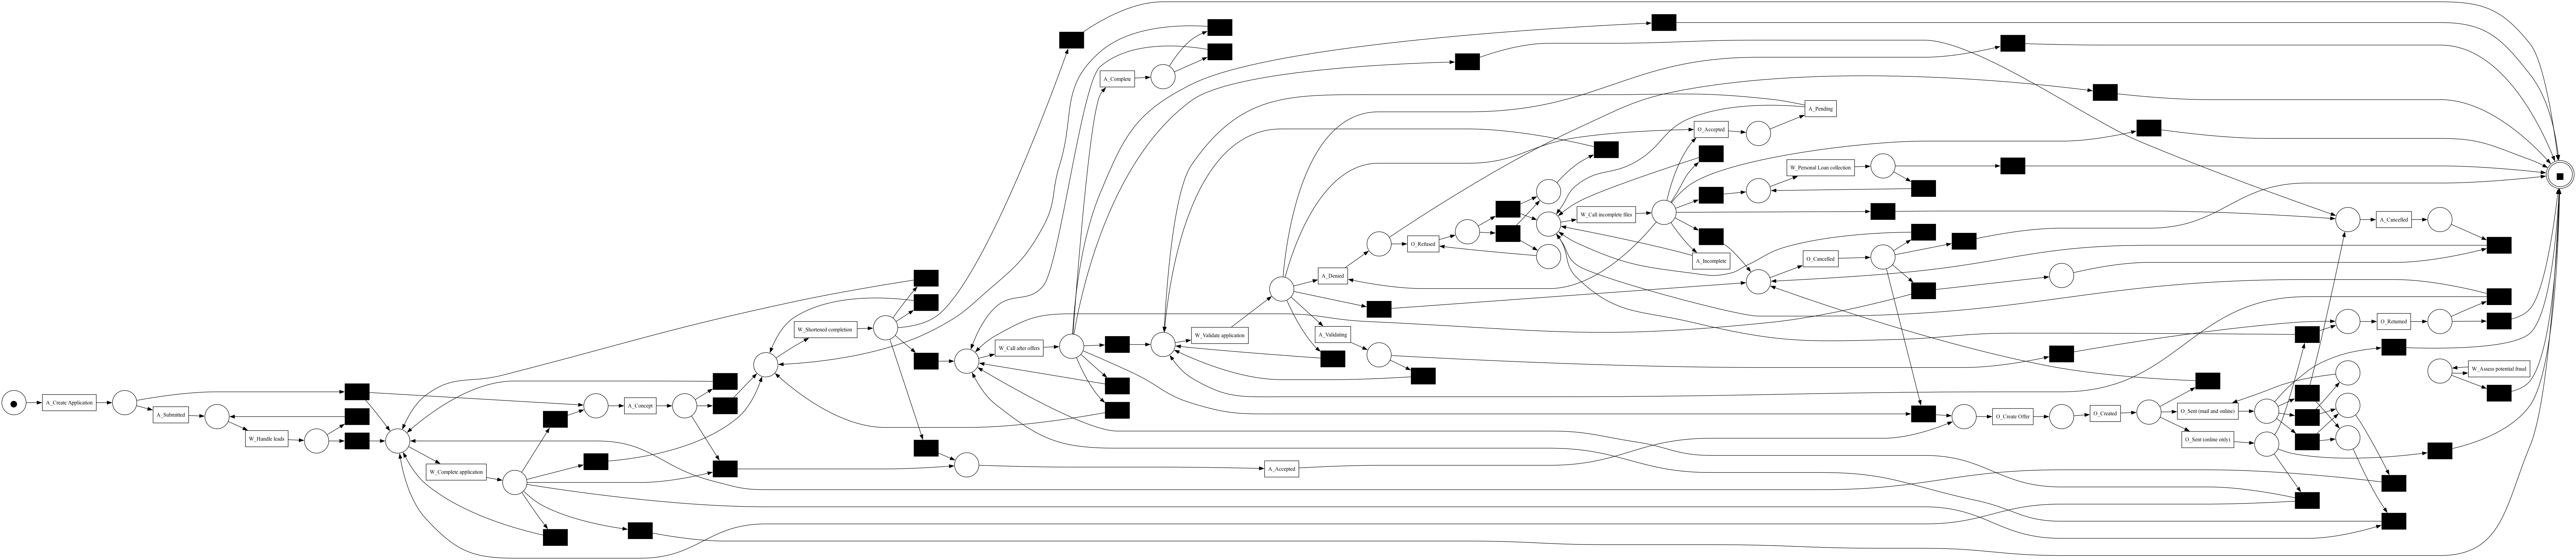

{'intplace_W_Call after offers': [{'A_Complete'}, {}], 'intplace_W_Validate application': [{'A_Denied'}, {'A_Validating'}, {'O_Accepted'}, {}], 'intplace_W_Assess potential fraud': [{'W_Assess potential fraud'}, {}], 'intplace_A_Denied': [{'O_Refused'}, {}], 'intplace_O_Created': [{'O_Sent (mail and online)'}, {'O_Sent (online only)'}, {}], 'intplace_W_Call incomplete files': [{'A_Incomplete'}, {'A_Denied'}, {'O_Accepted'}, {}], 'intplace_A_Create Application': [{'A_Submitted'}, {}]}


In [68]:
petri_heuristic, im_heuristic, fm_heuristic = pm4py.discover_petri_net_heuristics(log=log)

pm4py.view_petri_net(petri_heuristic, im_heuristic, fm_heuristic, log=log)


decision_points_heuristic = find_decision_points(petri_heuristic)
print(decision_points_heuristic)

In [7]:
process_tree = pm4py.discover_process_tree_inductive(log=log)

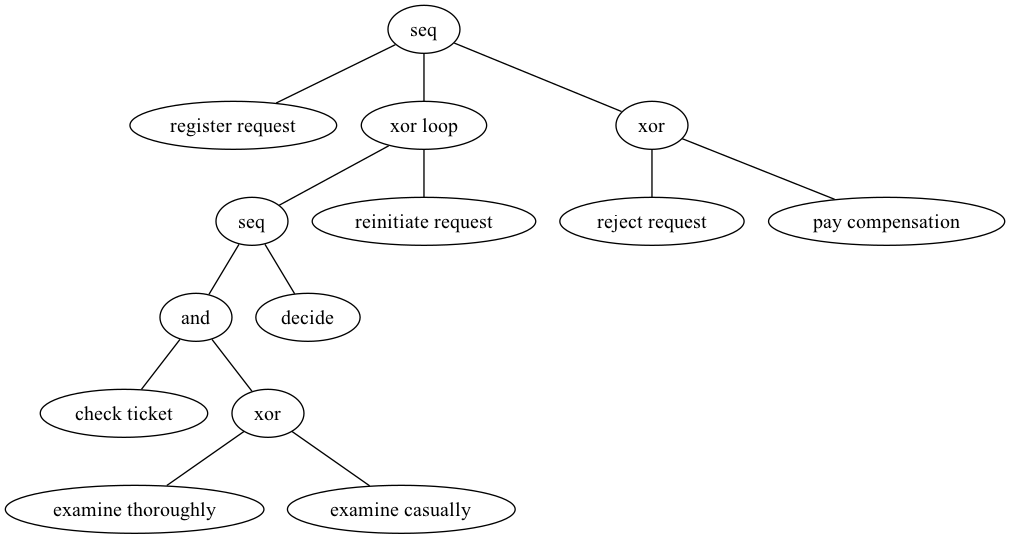

In [10]:
process_tree = pm4py.discover_process_tree_inductive(log=log)
pm4py.view_process_tree(process_tree,rankdir='TB')

In [79]:
# helper: simple arc-based graph helpers assume arc.source/arc.target refer to nodes
# petri.places, petri.transitions, petri.arcs exist

def find_decision_points_with_classes(petri):
    decision_points = {}

    for place in petri.places:
        # outgoing transitions from this place
        outgoing_transitions = [arc.target for arc in petri.arcs if arc.source == place]
        if len(outgoing_transitions) <= 1:
            continue

        # Precompute reachability (places) for each outgoing transition
        reachable_places_per_branch = []
        for t in outgoing_transitions:
            rp = reachable_places_from_transition(t, petri)
            reachable_places_per_branch.append(rp)

        decision_classes = []
        empty_count = 0

        for idx, t in enumerate(outgoing_transitions):
            # When tracing branch idx, provide other branches' reachable sets
            other_reachable = set().union(*[s for j,s in enumerate(reachable_places_per_branch) if j != idx])

            if is_visible(t) and not is_duplicate(t, petri):
                current = {t.label}
            else:
                current = trace_decision_class(t, petri, other_reachable, visited=set())
            if current:
                decision_classes.append(current)
            else:
                empty_count += 1

        if len(decision_classes) > 0:
            # If some branches had no visible evidence, include explicit tau/do-nothing branch
            if empty_count > 0:
                decision_classes.append({"tau (do nothing)"})
            decision_points[place.name] = decision_classes

    return decision_points


def reachable_places_from_transition(t_start, petri):
    """
    Breadth-first search collecting places reachable from transition t_start.
    This traversal ignores the join-stopping rule; it's used to detect merges.
    We follow transitions and places, but avoid infinite loops by visited set.
    """
    visited_places = set()
    visited_transitions = set()
    queue = []

    # successors: place arcs from transition
    succ_places = [arc.target for arc in petri.arcs if arc.source == t_start]
    for p in succ_places:
        queue.append(p)

    while queue:
        p = queue.pop(0)
        if p in visited_places:
            continue
        visited_places.add(p)

        # transitions outgoing from p
        succ_t = [arc.target for arc in petri.arcs if arc.source == p]
        for t in succ_t:
            if t in visited_transitions:
                continue
            visited_transitions.add(t)
            # add successor places of t
            for a in petri.arcs:
                if a.source == t:
                    if a.target not in visited_places:
                        queue.append(a.target)
    return visited_places


def trace_decision_class(t, petri, other_reachable_places, visited):
    """
    Recursively find visible labels reachable from t, but stop (return empty)
    if we encounter any place that is reachable from other branches (merge).
    visited is per-branch set of transitions/places to avoid infinite recursion.
    """
    decision_labels = set()

    # prevent infinite recursion across transitions
    if t in visited:
        return set()
    visited.add(t)

    succ_places = [arc.target for arc in petri.arcs if arc.source == t]
    if not succ_places:
        return set()

    for p in succ_places:
        # If this place appears in other branches' reachable set, it's a true merge: abort.
        if p in other_reachable_places:
            # merging join encountered — cannot attribute downstream activities to this branch
            return set()

        # Otherwise, continue; but avoid looping forever: track visited places too
        if ('place', p) in visited:
            continue
        visited.add(('place', p))

        succ_transitions = [arc.target for arc in petri.arcs if arc.source == p]
        for t2 in succ_transitions:
            # visible and unique transition => candidate label
            if is_visible(t2) and not is_duplicate(t2, petri):
                decision_labels.add(t2.label)
            else:
                # recurse with a copy of visited for per-path safety
                result = trace_decision_class(t2, petri, other_reachable_places, visited)
                # if result is empty due to hitting a merge deeper down, we must return empty per paper
                if not result:
                    return set()
                decision_labels |= result

    return decision_labels


# helpers (unchanged mostly)
def is_visible(t):
    # visible if label is present and non-empty (t.label could be None or "")
    return getattr(t, "label", None)

def is_duplicate(t, petri):
    label = getattr(t, "label", None)
    if not label:
        return False
    same = [tr for tr in petri.transitions if getattr(tr, "label", None) == label]
    return len(same) > 1

def is_join_construct(place, petri):
    incoming = [arc.source for arc in petri.arcs if arc.target == place]
    return len(incoming) > 1

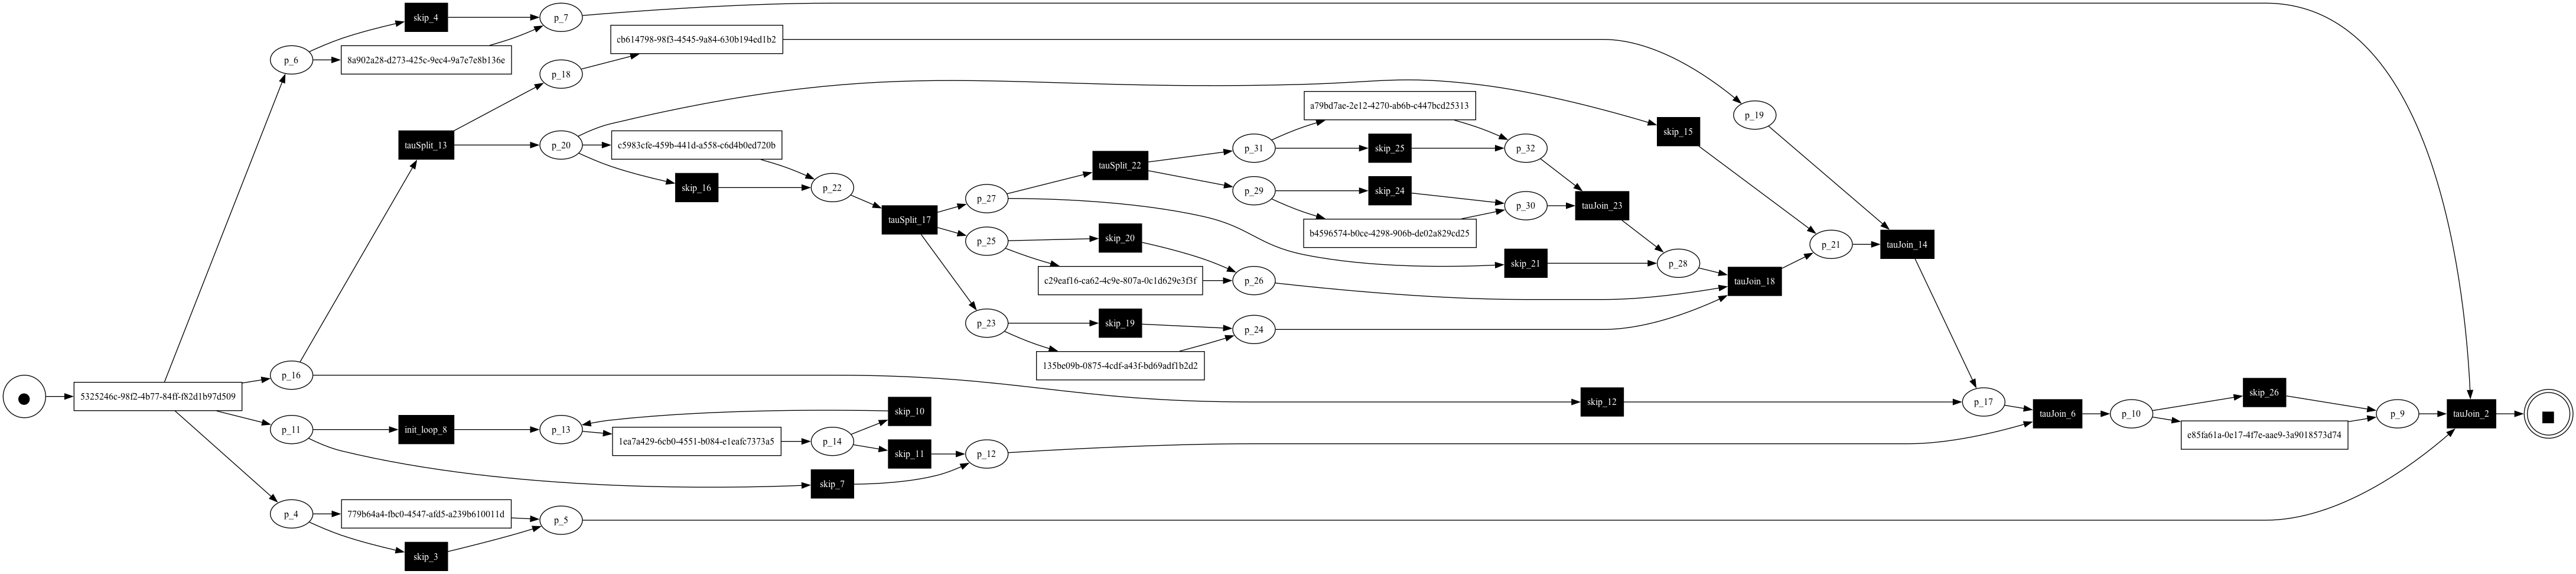

{'p_11': [{'Payment'}, {'τ (do nothing)'}], 'p_14': [{'Payment'}, {'τ (do nothing)'}], 'p_6': [{'Insert Date Appeal to Prefecture'}, {'τ (do nothing)'}], 'p_20': [{'Insert Fine Notification'}, {'τ (do nothing)'}], 'p_25': [{'Add penalty'}, {'τ (do nothing)'}], 'p_4': [{'Send Appeal to Prefecture'}, {'τ (do nothing)'}], 'p_10': [{'Send for Credit Collection'}, {'τ (do nothing)'}], 'p_23': [{'Receive Result Appeal from Prefecture'}, {'τ (do nothing)'}], 'p_29': [{'Appeal to Judge'}, {'τ (do nothing)'}], 'p_31': [{'Notify Result Appeal to Offender'}, {'τ (do nothing)'}]}


In [100]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import pm4py

# Discover Petri net
petri_inductive, im_inductive, fm_inductive = pm4py.discover_petri_net_inductive(log=log)

# Add readable names for unlabeled places
for i, place in enumerate(petri_inductive.places):
    if not place.name:
        place.name = f"p_{i}"

# Visualization parameters (this actually works)
parameters = {
    # "show_places_names": True,
    "debug":True,
    "format": "png",
    "rankdir": "LR"   # optional: left-to-right layout
}

# Apply visualization manually instead of using pm4py.view_petri_net
gviz = pn_visualizer.apply(petri_inductive, im_inductive, fm_inductive, parameters=parameters)
pn_visualizer.view(gviz)

# Decision points
decision_points_inductive = find_decision_points_with_classes(petri_inductive)
print(decision_points_inductive)

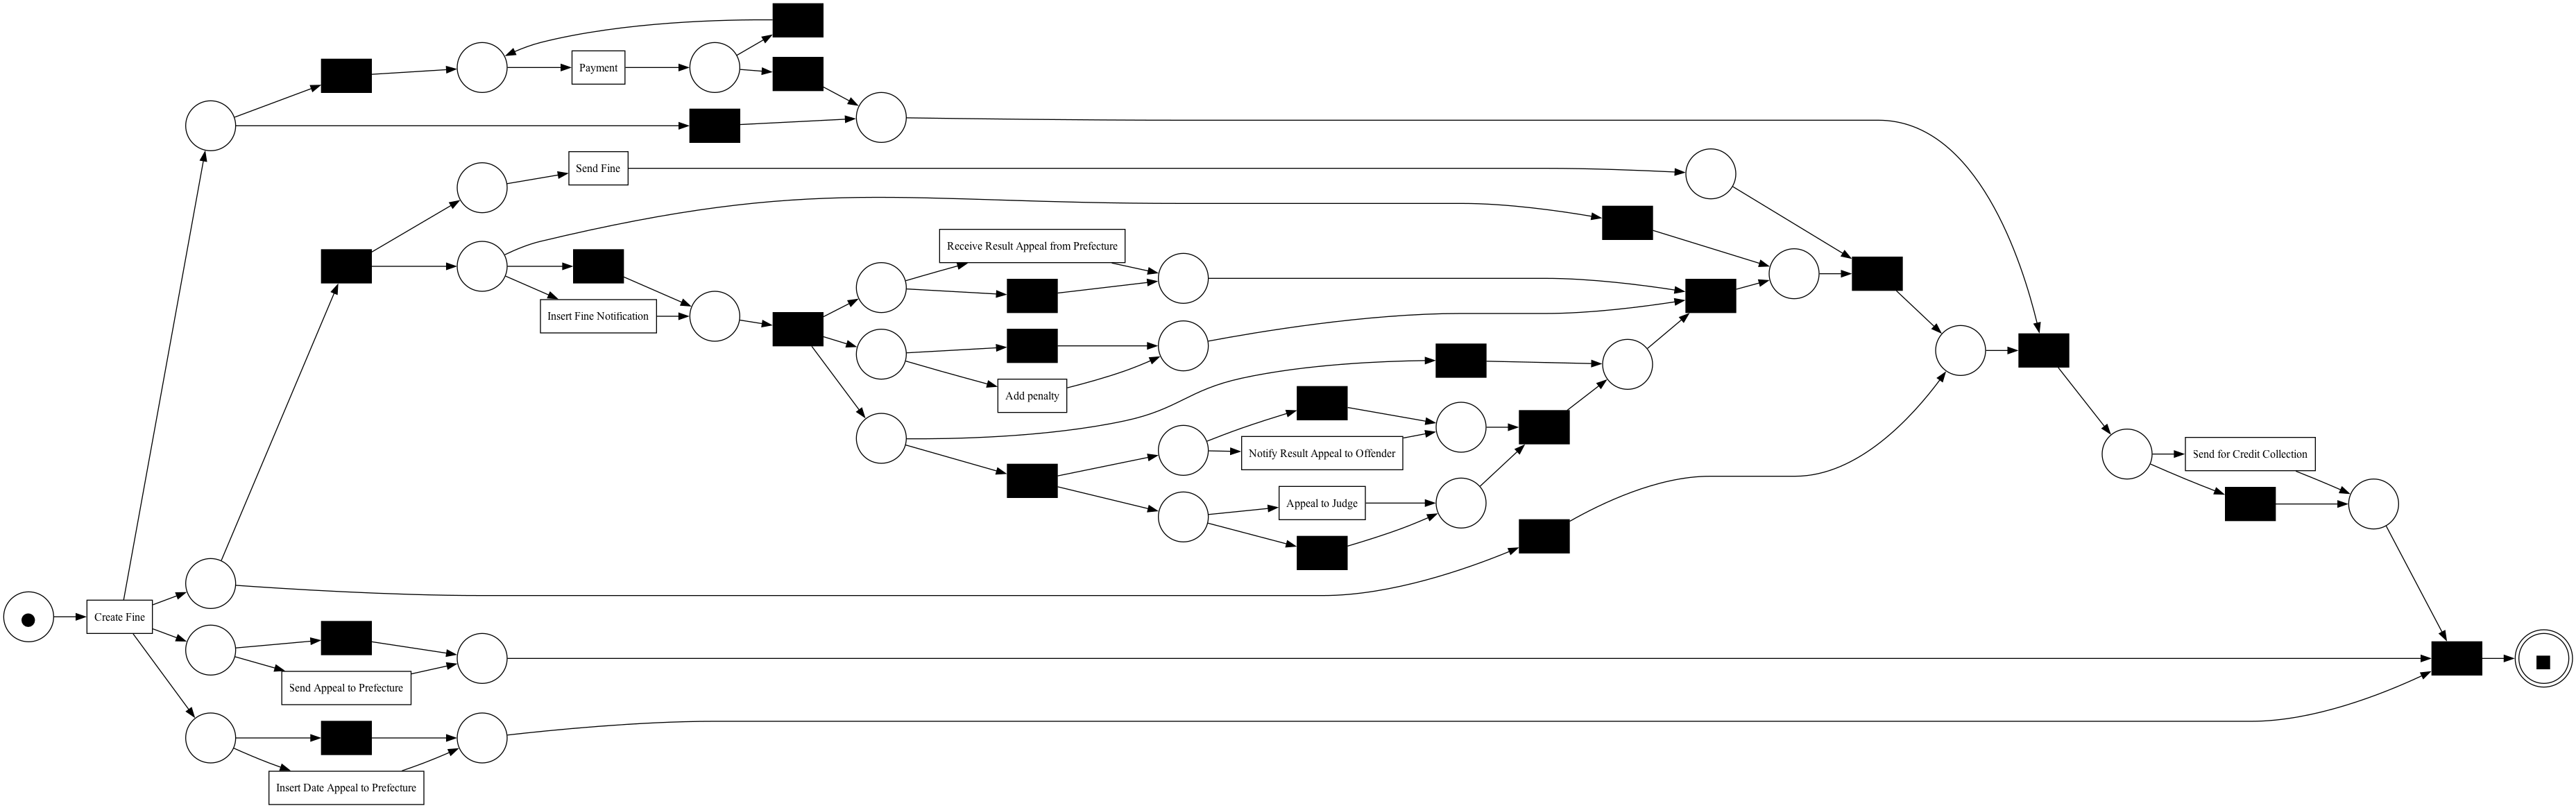

TypeError: trace_decision_class() missing 2 required positional arguments: 'other_reachable_places' and 'visited'

In [97]:
petri_inductive, im_inductive, fm_inductive = pm4py.discover_petri_net_inductive(log=log)


pm4py.view_petri_net(petri_inductive, im_inductive, fm_inductive, log=log)

decision_points_inductive = find_decision_points(petri_inductive)

print(decision_points_inductive)
# for dp in decision_points_inductive:
#     print(dp, "\n")


In [10]:
petri = petri_alpha
decision_points = find_decision_points(petri)

print(decision_points)

{0: ['reinitiate request', 'pay compensation', 'reject request'], 1: ['examine casually', 'examine thoroughly']}


In [11]:
trace_length = 5
rows = []

for trace in log:
    case_id = trace.attributes.get('concept:name') or trace.attributes.get('case:concept:name')
    activity_trace = []  # store sequence of activities so far

    for idx, event in enumerate(trace):
        activity = event['concept:name']

        # Collect previous activities (up to trace_length)
        previous_activities = activity_trace[-trace_length:]  # last `trace_length` activities

        # Pad with None if fewer than trace_length
        previous_activities = [None]*(trace_length - len(previous_activities)) + previous_activities

        for dp_id, options in decision_points.items():
            if activity in options:
                row = {
                    "decision_point": dp_id,
                    "case_id": case_id,
                    "activity": activity,
                    "employee": event['org:resource'],
                    "timestamp": event['time:timestamp'],
                    "cost": event['Costs'],
                }

                # Add previous activities as separate columns
                for i in range(trace_length):
                    row[f'previous_activity_{i+1}'] = previous_activities[i]

                rows.append(row)

        # update activity sequence
        activity_trace.append(activity)

df_decision_full = pd.DataFrame(rows)
df_decision_full

decision_point case_id            activity employee  \
0                1       3    examine casually     Mike   
1                0       3  reinitiate request     Sara   
2                1       3  examine thoroughly     Sean   
3                0       3    pay compensation    Ellen   
4                1       2    examine casually     Sean   
5                0       2    pay compensation    Ellen   
6                1       1  examine thoroughly      Sue   
7                0       1      reject request     Pete   
8                1       6    examine casually    Ellen   
9                0       6    pay compensation     Mike   
10               1       5    examine casually     Mike   
11               0       5  reinitiate request     Sara   
12               1       5    examine casually     Mike   
13               0       5  reinitiate request     Sara   
14               1       5    examine casually      Sue   
15               0       5      reject request     Mike   
16               1       4  examine thoroughly     Sean   
17               0       4      reject request    Ellen   

                   timestamp cost previous_activity_1 previous_activity_2  \
0  2010-12-30 15:06:00+00:00  400                None                None   
1  2011-01-06 12:18:00+00:00  200                None    register request   
2  2011-01-06 13:06:00+00:00  400    register request    examine casually   
3  2011-01-15 10:45:00+00:00  200              decide  reinitiate request   
4  2010-12-30 14:16:00+00:00  400                None                None   
5  2011-01-08 12:05:00+00:00  200                None    register request   
6  2010-12-31 10:06:00+00:00  400                None                None   
7  2011-01-07 14:24:00+00:00  200                None    register request   
8  2011-01-06 16:06:00+00:00  400                None                None   
9  2011-01-16 11:47:00+00:00  200                None    register request   
10 2011-01-07 10:16:00+00:00  400                None                None   
11 2011-01-11 16:18:00+00:00  200                None    register request   
12 2011-01-16 15:50:00+00:00  400    examine casually        check ticket   
13 2011-01-20 12:48:00+00:00  200              decide  reinitiate request   
14 2011-01-21 09:06:00+00:00  400  reinitiate request        check ticket   
15 2011-01-24 14:56:00+00:00  200              decide  reinitiate request   
16 2011-01-08 14:43:00+00:00  400                None                None   
17 2011-01-12 15:44:00+00:00  200                None    register request   

   previous_activity_3 previous_activity_4 previous_activity_5  
0                 None                None    register request  
1     examine casually        check ticket              decide  
2         check ticket              decide  reinitiate request  
3   examine thoroughly        check ticket              decide  
4                 None    register request        check ticket  
5         check ticket    examine casually              decide  
6                 None                None    register request  
7   examine thoroughly        check ticket              decide  
8                 None                None    register request  
9     examine casually        check ticket              decide  
10                None                None    register request  
11    examine casually        check ticket              decide  
12              decide  reinitiate request        check ticket  
13        check ticket    examine casually              decide  
14    examine casually              decide  reinitiate request  
15    examine casually        check ticket              decide  
16                None    register request        check ticket  
17        check ticket  examine thoroughly              decide

In [12]:
decision_point_trees = {}

for dp_id, df_dp in df_decision_full.groupby("decision_point"):
    # Features
    exclude_cols = ['case_id', 'activity', 'decision_point']
    X = df_dp[[c for c in df_dp.columns if c not in exclude_cols]].fillna('None')

    # Convert to strings for LabelEncoder
    for col in X.columns:
        X[col] = X[col].astype(str)

    # Encode features
    le_dict = {}
    for col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        le_dict[col] = le

    # Encode label
    y = df_dp['activity'].astype(str)
    le_y = LabelEncoder()
    y_encoded = le_y.fit_transform(y)

    # Train Decision Tree
    clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    clf.fit(X, y_encoded)

    # Store classifier and encoders
    decision_point_trees[dp_id] = {
        "clf": clf,
        "feature_encoders": le_dict,
        "label_encoder": le_y,
        "features": X.columns.tolist()
    }

print(f"Trained Decision Trees for {len(decision_point_trees)} decision points")

Trained Decision Trees for 2 decision points


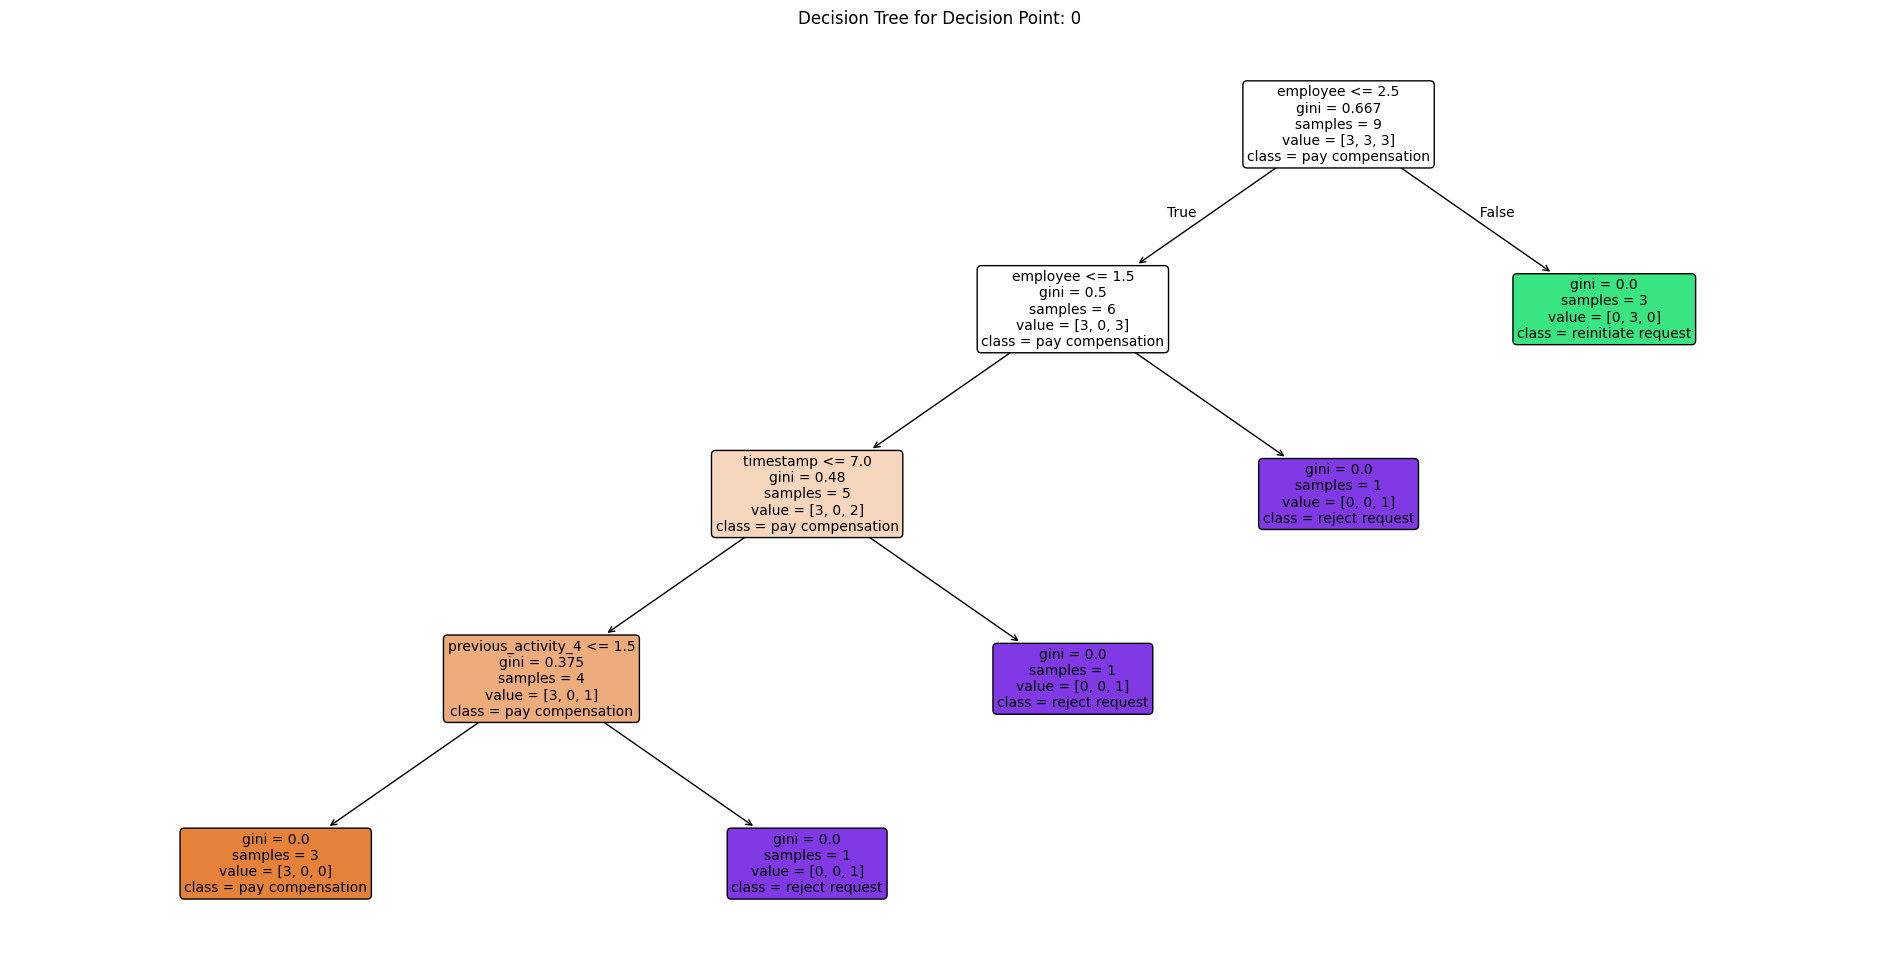

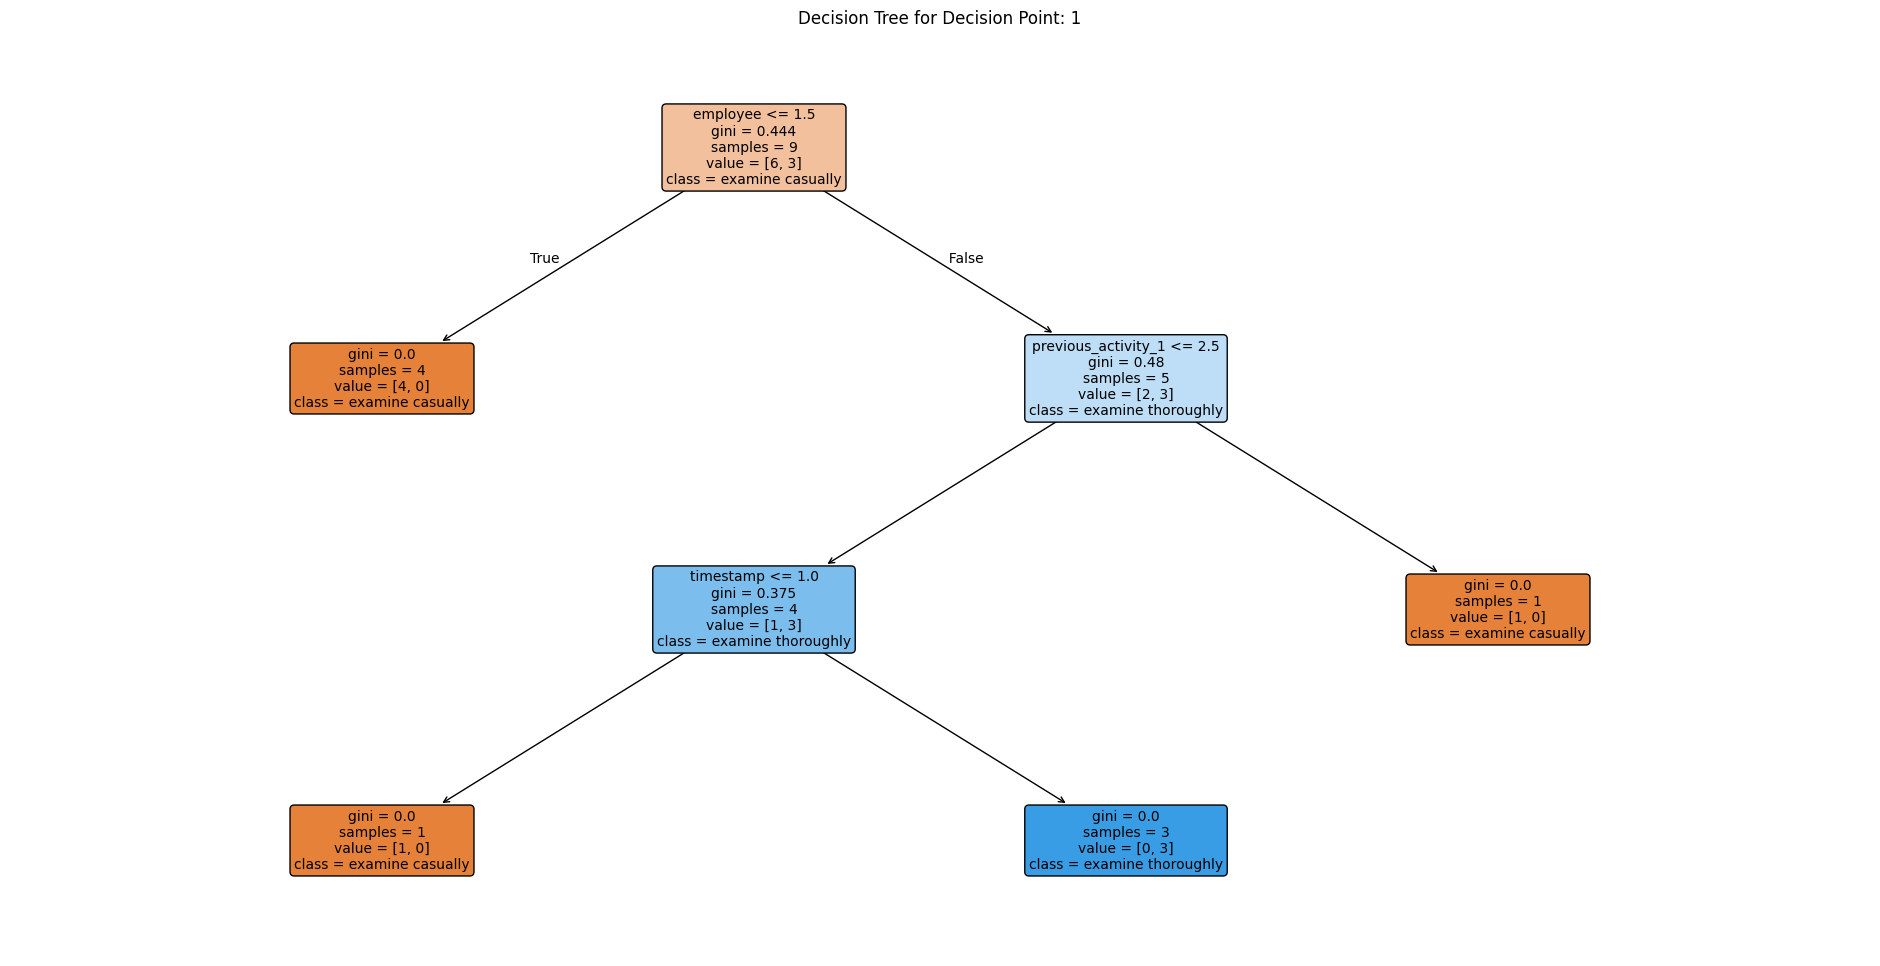

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

for dp_id, dp_data in decision_point_trees.items():
    clf = dp_data["clf"]
    feature_names = dp_data["features"]
    label_encoder = dp_data["label_encoder"]

    plt.figure(figsize=(24, 12))
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=label_encoder.classes_,
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title(f"Decision Tree for Decision Point: {dp_id}")
    plt.show()

In [14]:
from sklearn.tree import export_text

from sklearn.tree import export_text

def readable_tree(dp_id, dp_data):
    clf = dp_data["clf"]
    feature_names = dp_data["features"]
    feature_encoders = dp_data.get("feature_encoders", {})
    label_encoder = dp_data.get("label_encoder", None)

    # Get the raw text rules
    rules = export_text(clf, feature_names=feature_names)

    # Replace numeric thresholds with categorical names
    for feature, le in feature_encoders.items():
        for i, cls in enumerate(le.classes_):
            # Replace "feature <= i.5" with "feature in ['cls']"
            rules = rules.replace(f"{feature} <= {i + 0.5}", f"{feature} == '{cls}'")
            # Replace "feature > i.5" with "feature in [next_class,...]"
            if i + 1 < len(le.classes_):
                next_classes = "', '".join(le.classes_[i+1:])
                rules = rules.replace(f"{feature} > {i + 0.5}", f"{feature} in ['{next_classes}']")
            else:
                rules = rules.replace(f"{feature} > {i + 0.5}", f"{feature} != '{cls}'")

    # Replace target indices with class names
    if label_encoder is not None:
        for i, cls in enumerate(label_encoder.classes_):
            rules = rules.replace(f"class: {i}", f"class: '{cls}'")

    print(f"\n{'='*80}\nDecision Point: {dp_id}\n{'='*80}")
    print(rules)

# Example usage:
for dp_id, dp_data in decision_point_trees.items():
    readable_tree(dp_id, dp_data)


Decision Point: 0
|--- employee == 'Pete'0
|   |--- employee == 'Mike'0
|   |   |--- timestamp <= 7.00
|   |   |   |--- previous_activity_4 == 'examine casually'0
|   |   |   |   |--- class: 'pay compensation'
|   |   |   |--- previous_activity_4 >  1.50
|   |   |   |   |--- class: 'reject request'
|   |   |--- timestamp >  7.00
|   |   |   |--- class: 'reject request'
|   |--- employee >  1.50
|   |   |--- class: 'reject request'
|--- employee >  2.50
|   |--- class: 'reinitiate request'


Decision Point: 1
|--- employee == 'Mike'0
|   |--- class: 'examine casually'
|--- employee >  1.50
|   |--- previous_activity_1 == 'register request'0
|   |   |--- timestamp <= 1.00
|   |   |   |--- class: 'examine casually'
|   |   |--- timestamp >  1.00
|   |   |   |--- class: 'examine thoroughly'
|   |--- previous_activity_1 >  2.50
|   |   |--- class: 'examine casually'



In [17]:
pd.read_csv("data/Tr.csv", sep=";")

decision_point                  activity lifecycle  expense  \
0       intplace_Create Fine                 Send Fine  complete    11.00   
1       intplace_Create Fine                 Send Fine  complete    11.00   
2         intplace_Send Fine  Insert Fine Notification  complete      NaN   
3       intplace_Create Fine                 Send Fine  complete    13.00   
4         intplace_Send Fine  Insert Fine Notification  complete      NaN   
...                      ...                       ...       ...      ...   
190433    intplace_Send Fine  Insert Fine Notification  complete      NaN   
190434  intplace_Create Fine                 Send Fine  complete    10.00   
190435    intplace_Send Fine  Insert Fine Notification  complete      NaN   
190436  intplace_Create Fine                 Send Fine  complete    15.16   
190437    intplace_Send Fine  Insert Fine Notification  complete      NaN   

                             time  Insert Date Appeal to Prefecture  Payment  \
0       2006-12-05 00:00:00+00:00                                 0        0   
1       2006-12-12 00:00:00+00:00                                 0        0   
2       2007-01-15 00:00:00+00:00                                 0        0   
3       2007-07-17 00:00:00+00:00                                 0        0   
4       2007-08-02 00:00:00+00:00                                 0        0   
...                           ...                               ...      ...   
190433  2002-11-04 00:00:00+00:00                                 0        0   
190434  2002-10-25 00:00:00+00:00                                 0        0   
190435  2002-10-31 00:00:00+00:00                                 0        0   
190436  2002-10-25 00:00:00+00:00                                 0        0   
190437  2002-11-04 00:00:00+00:00                                 0        0   

        Receive Result Appeal from Prefecture  Send for Credit Collection  \
0                                           0                           0   
1                                           0                           0   
2                                           0                           0   
3                                           0                           0   
4                                           0                           0   
...                                       ...                         ...   
190433                                      0                           0   
190434                                      0                           0   
190435                                      0                           0   
190436                                      0                           0   
190437                                      0                           0   

        Notify Result Appeal to Offender  ...  Insert Fine Notification  \
0                                      0  ...                         0   
1                                      0  ...                         0   
2                                      0  ...                         1   
3                                      0  ...                         0   
4                                      0  ...                         1   
...                                  ...  ...                       ...   
190433                                 0  ...                         1   
190434                                 0  ...                         0   
190435                                 0  ...                         1   
190436                                 0  ...                         0   
190437                                 0  ...                         1   

        Send Appeal to Prefecture  Send Fine  Appeal to Judge  Create Fine  \
0                               0          1                0            1   
1                               0          1                0            1   
2                               0          1                0       

In [ ]:
['amount', , '', '', 'vehicleClass', 'totalPaymentAmount', , , 'article', 'points', 'case:concept:name', , '', '', 'paymentAmount', '']